In [1]:
%pip install rarfile

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import rarfile
import shutil
from tqdm import tqdm

# === 1. Extraer el archivo RAR ===
rar_path = '/content/DL.rar'
extract_path = '/content/dataset_raw'

with rarfile.RarFile(rar_path, 'r') as rf:
    rf.extractall(extract_path)

print("✅ Extracción completa en:", extract_path)

# === 2. Crear DataFrame con rutas y labels ===
class_labels = [str(i) for i in range(8)]  # Clases 0-7

data = []
for label in class_labels:
    folder = os.path.join(extract_path, label)
    if os.path.exists(folder):
        for img in os.listdir(folder):
            data.append({"image_path": os.path.join(folder, img), "label": int(label)})

df = pd.DataFrame(data)
print(f"✅ Total de imágenes encontradas: {len(df)}")
display(df.head())

# === 3. Dividir dataset en train/val/test ===
X_train, X_temp, y_train, y_temp = train_test_split(
    df["image_path"], df["label"],
    test_size=0.3, stratify=df["label"], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

print(f"📊 Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# === 4. Función para organizar en carpetas ===
def create_split_folders(X, y, split_name, base_dir="/content/dataset"):
    for path, label in tqdm(zip(X, y), total=len(X), desc=f"Organizando {split_name}"):
        split_dir = os.path.join(base_dir, split_name, str(label))
        os.makedirs(split_dir, exist_ok=True)
        shutil.copy(path, split_dir)

# Crear carpetas finales
create_split_folders(X_train, y_train, "train")
create_split_folders(X_val, y_val, "val")
create_split_folders(X_test, y_test, "test")

print("✅ Dataset organizado en /content/dataset (train/val/test con subcarpetas por clase)")


✅ Extracción completa en: /content/dataset_raw
✅ Total de imágenes encontradas: 33725


,image_path,label
0,/content/dataset_raw/0/img_9172.png,0
1,/content/dataset_raw/0/img_7061.png,0
2,/content/dataset_raw/0/img_9070.png,0
3,/content/dataset_raw/0/img_779.png,0
4,/content/dataset_raw/0/img_16172.png,0


📊 Train: 23607 | Val: 5059 | Test: 5059


Organizando test: 100%|██████████| 5059/5059 [00:00<00:00, 8050.61it/s]

✅ Dataset organizado en /content/dataset (train/val/test con subcarpetas por clase)


In [3]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Determine the number of classes
# Assuming labels are 0-7, so there are 8 classes
num_classes = 8

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print("Labels one-hot encoded.")
print(f"Shape of training labels: {y_train_encoded.shape}")
print(f"Shape of validation labels: {y_val_encoded.shape}")
print(f"Shape of testing labels: {y_test_encoded.shape}")

Labels one-hot encoded.
Shape of training labels: (23607, 8)
Shape of validation labels: (5059, 8)
Shape of testing labels: (5059, 8)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define the target image size
IMG_WIDTH = 224
IMG_HEIGHT = 224
num_classes = 8

# Define the input layer
input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Load EfficientNetB0 with pre-trained weights (ImageNet), exclude top
model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

model.summary()

# Add new layers for our classification task
x = Flatten()(model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  #ajuste de Dropout para minimizar overfiting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
transfer_model = Model(inputs=model.input, outputs=predictions)

# Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,108,203 (76.71 MB)

 Trainable params: 20,066,180 (76.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Build the Transfer Learning Model

Now, we will add new layers on top of the pre-trained VGG16 base model to create a model for our 8-class classification task.

In [5]:
import tensorflow as tf

# Define the directory where the dataset is organized
base_dir = "/content/dataset"

# Define image size and batch size (assuming IMG_WIDTH, IMG_HEIGHT are defined)
IMG_WIDTH = 224
IMG_HEIGHT = 224
num_epochs = 10 # Define the number of training epochs
batch_s = 32 # Define batch size here

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{base_dir}/train',
    labels='inferred',
    label_mode='categorical', # Use categorical for one-hot encoded labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest',
    batch_size=batch_s,
    shuffle=True
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{base_dir}/val',
    labels='inferred',
    label_mode='categorical', # Use categorical for one-hot encoded labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest',
    batch_size=batch_s,
    shuffle=False # No need to shuffle validation data
)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=f'{base_dir}/test',
    labels='inferred',
    label_mode='categorical', # Use categorical for one-hot encoded labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='nearest',
    batch_size=batch_s,
    shuffle=False # No need to shuffle test data
)

print("Image datasets created.")

Found 23607 files belonging to 8 classes.
Found 5059 files belonging to 8 classes.
Found 5059 files belonging to 8 classes.
Image datasets created.


In [6]:

history_transfer = transfer_model.fit(
    train_ds,        # Use the training dataset
    epochs=num_epochs, # Use the defined number of epochs
    validation_data=val_ds # Use the validation dataset for validation
)

Epoch 1/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 245s 221ms/step - accuracy: 0.8342 - loss: 0.5122 - val_accuracy: 0.9569 - val_loss: 0.1360
Epoch 2/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 154s 141ms/step - accuracy: 0.9643 - loss: 0.1053 - val_accuracy: 0.9597 - val_loss: 0.1329
Epoch 3/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.9798 - loss: 0.0558 - val_accuracy: 0.9634 - val_loss: 0.1416
Epoch 4/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 144s 145ms/step - accuracy: 0.9868 - loss: 0.0363 - val_accuracy: 0.9644 - val_loss: 0.1341
Epoch 5/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 104s 141ms/step - accuracy: 0.9908 - loss: 0.0309 - val_accuracy: 0.9652 - val_loss: 0.1401
Epoch 6/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 145s 145ms/step - accuracy: 0.9907 - loss: 0.0269 - val_accuracy: 0.9615 - val_loss: 0.1744
Epoch 7/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.9903 - loss: 0.0295 - val_accuracy: 0.9628 - val_loss: 0.1780
Epoch 8/10
738/738 ━━━━━━━━━━━━━━━━━━━━ 105s 142ms/step - accuracy: 0.9911 -

159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9465 - loss: 0.3085
Test Loss: 0.19395112991333008
Test Accuracy: 0.965210497379303
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step


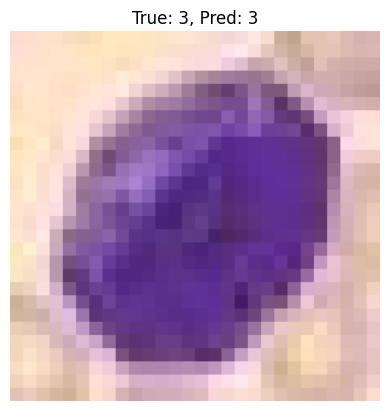


True Label: 3
Predicted Label: 3


In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# --- Evaluación ---
loss, accuracy = transfer_model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# --- Predicciones ---
predictions = transfer_model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Etiquetas verdaderas
true_labels = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_labels = tf.argmax(true_labels, axis=1).numpy()

# Nombres de clases correctos (viene del dataset)
class_names = test_ds.class_names

# --- Mostrar una imagen aleatoria del dataset ---
# Selecciona un índice válido
random_index = random.randint(0, len(true_labels) - 1)

# Reconstruye el batch en arrays
images = tf.concat([x for x, y in test_ds], axis=0).numpy()

# Imagen, label real y predicho
random_image = images[random_index].astype("uint8")
random_true_label = true_labels[random_index]
random_predicted_label = predicted_labels[random_index]

plt.imshow(random_image)
plt.title(f"True: {class_names[random_true_label]}, Pred: {class_names[random_predicted_label]}")
plt.axis("off")
plt.show()

print(f"\nTrue Label: {class_names[random_true_label]}")
print(f"Predicted Label: {class_names[random_predicted_label]}")